In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

In [ ]:
train = pd.read_csv('/content/train.csv')
test  = pd.read_csv('/content/test.csv')

train.shape, test.shape

((41300, 785), (28000, 784))

In [ ]:
X_train = train.drop('label',axis=1)
y_train = train['label']

X_test = test.copy()

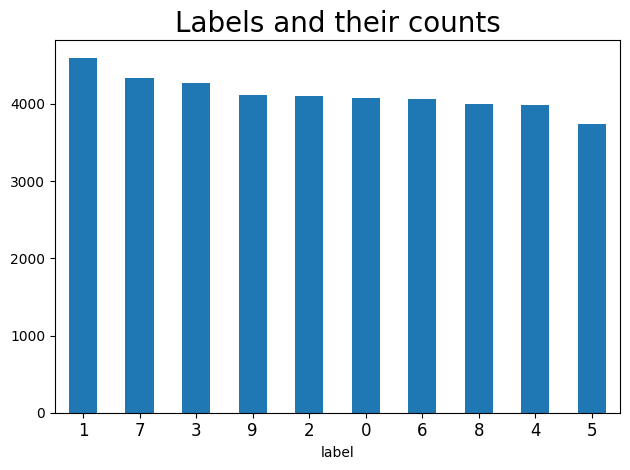

In [ ]:
y_train.value_counts().plot(kind='bar',legend=None)
plt.xticks(fontsize=12,rotation=0)

plt.title('Labels and their counts',fontsize=20)

plt.tight_layout()

In [ ]:
import collections

# Sample list of class labels (replace this with your actual class labels)
# Example: class_labels = [1, 2, 3, 1, 5, 6, 2, 3, 1, 6, 5, 2]
class_labels = []  # Load your class labels here

# Use collections.Counter to count the occurrences of each class
class_counts = collections.Counter(class_labels)

# Print the counts of each class
print("Class distribution:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples")


Class distribution:


In [ ]:
# Normalize the data
X_train = X_train / 255.0
X_test  = X_test / 255.0

In [ ]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_test  = X_test.values.reshape(-1,28,28,1)

Text(0.5, 1.0, 'Encoded label: 7')

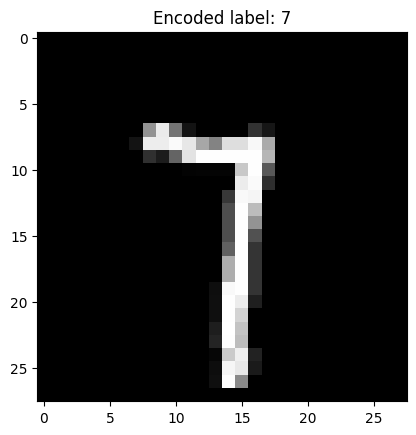

In [ ]:
classes = y_train.unique().astype(str)

i = np.random.choice(len(X_train))
plt.imshow(X_train[i],cmap='gray')
plt.title(f"Encoded label: {y_train[i]}")

In [ ]:
# Train-validation splitting
X_train2,X_validation,y_train2,y_validation = train_test_split(X_train,y_train,
                                                             test_size=0.3,random_state=0)

In [ ]:
# Convolution expects height x width x color
X_train2 = np.expand_dims(X_train2,-1)
X_validation = np.expand_dims(X_validation,-1)
print(X_train2.shape, X_validation.shape)

(28910, 28, 28, 1, 1) (12390, 28, 28, 1, 1)


In [ ]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001,rho=0.9,epsilon=1e-08,decay=0.0)

# Defining the learning rate reduction routine
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0000001)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# Defining the checkpoint callback
checkpoint_path = "results.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_freq='epoch')

In [ ]:
DROPOUT = 0.25


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),  # Assuming input size is reduced
    tf.keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same"),  # Reduced filters
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(10, activation="softmax")
])


In [ ]:
# Define the optimizer AFTER creating the model
optimizer = RMSprop(learning_rate=0.001,rho=0.9,epsilon=1e-08,decay=0.0) # Moved here

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=optimizer,
                 metrics=["accuracy"])

# Fit the model (to the normalized data)
history = model.fit(X_train2,y_train2,
                      epochs=40,
                      batch_size=32,
                      validation_data=(X_validation,y_validation),
                      callbacks=[learning_rate_reduction,checkpoint_callback])

Epoch 1/40
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8052 - loss: 0.6117
Epoch 1: val_accuracy improved from -inf to 0.97401, saving model to results.weights.h5
904/904 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8053 - loss: 0.6114 - val_accuracy: 0.9740 - val_loss: 0.0860 - learning_rate: 0.0010
Epoch 2/40
887/904 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9600 - loss: 0.1271
Epoch 2: val_accuracy did not improve from 0.97401
904/904 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9601 - loss: 0.1270 - val_accuracy: 0.9739 - val_loss: 0.0880 - learning_rate: 0.0010
Epoch 3/40
903/904 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9714 - loss: 0.0944
Epoch 3: val_accuracy improved from 0.97401 to 0.98345, saving model to results.weights.h5
904/904 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9714 - loss: 0.0944 - val_accuracy: 0.9835 - val_loss: 0.0552 - learning_rate: 0.0010
Epoch 4/40
900/904 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9751 - loss: 0.0816
Ep

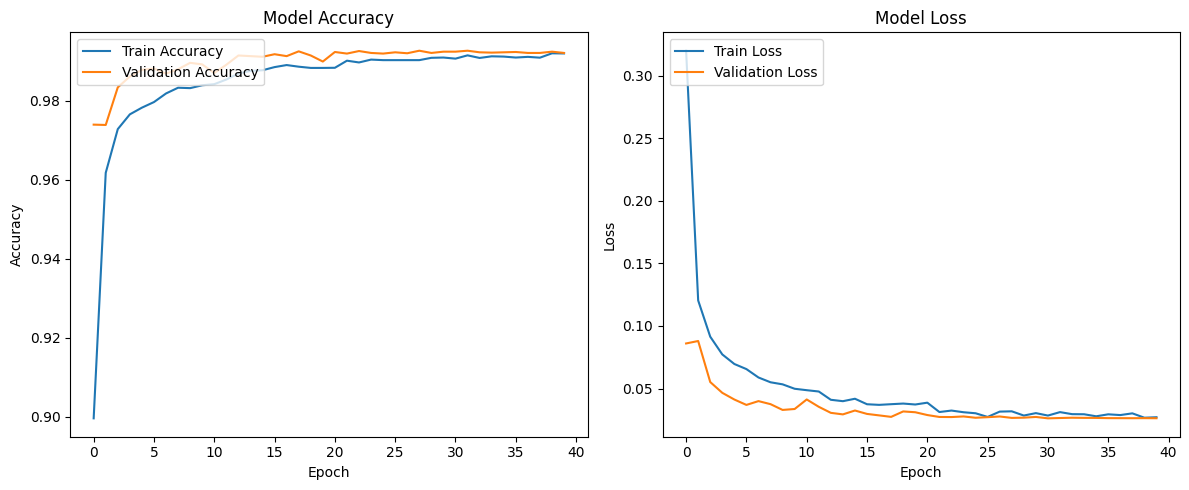

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
model.load_weights(checkpoint_path)
loss,acc = model.evaluate(X_validation,y_validation,verbose=0)

print('Restored model')
print('Test Loss: {:.4f}'.format(loss))
print('Test Accuracy: {:.4f}'.format(acc))

Restored model
Test Loss: 0.0265
Test Accuracy: 0.9927


In [ ]:
from tensorflow.keras.models import save_model

# Save Model
model.save('mnist_digit_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Detected Digit: 1 with confidence 67.4% at center (203, 588)


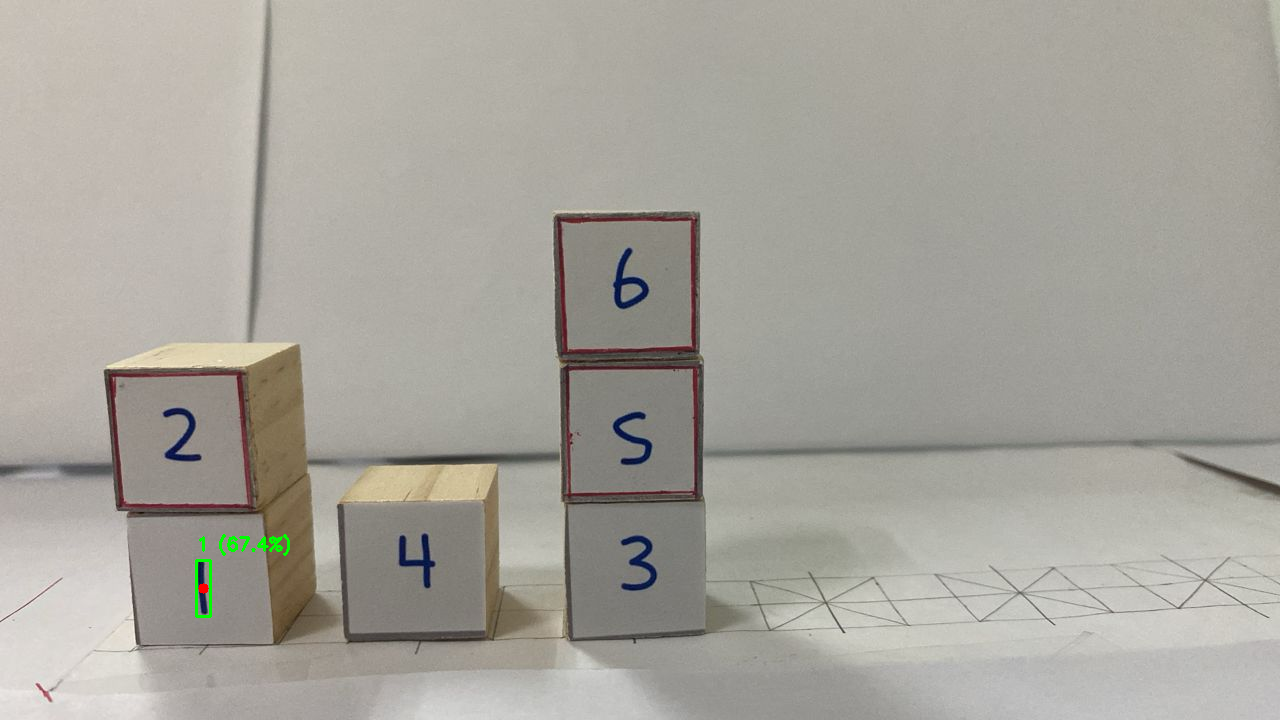

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Detected Digit: 3 with confidence 100.0% at center (639, 563)


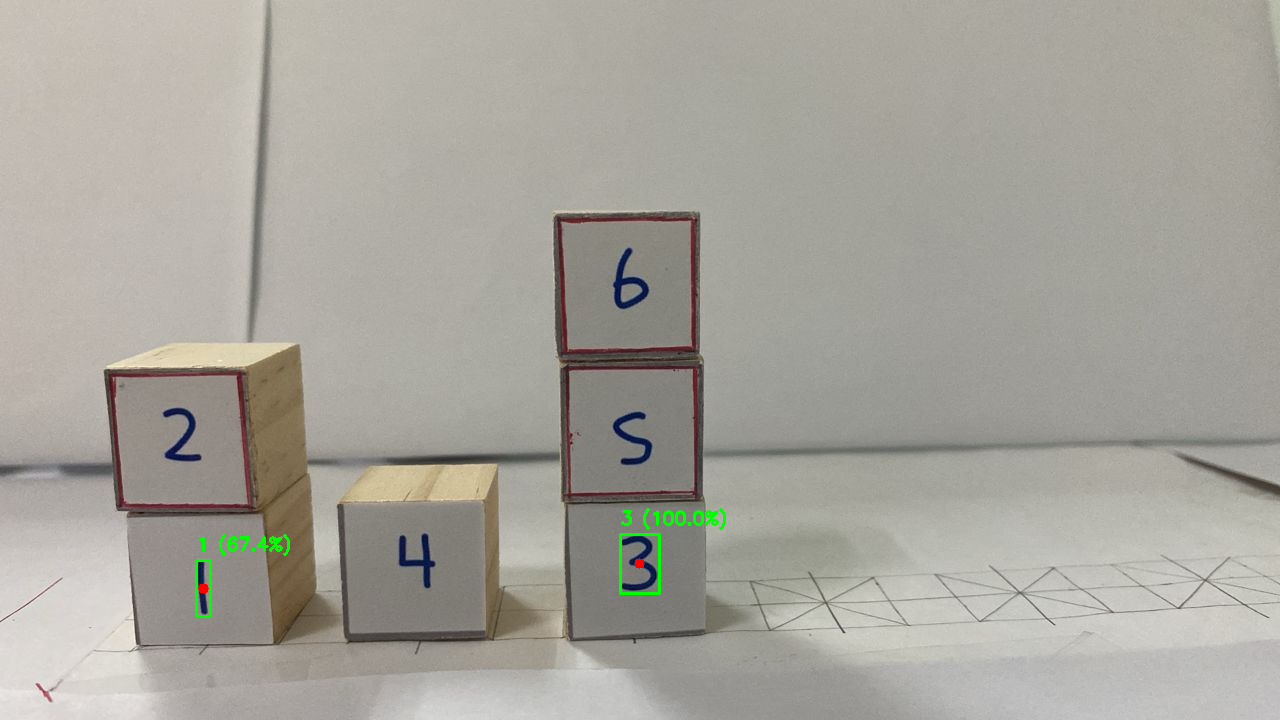

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Detected Digit: 4 with confidence 100.0% at center (417, 561)


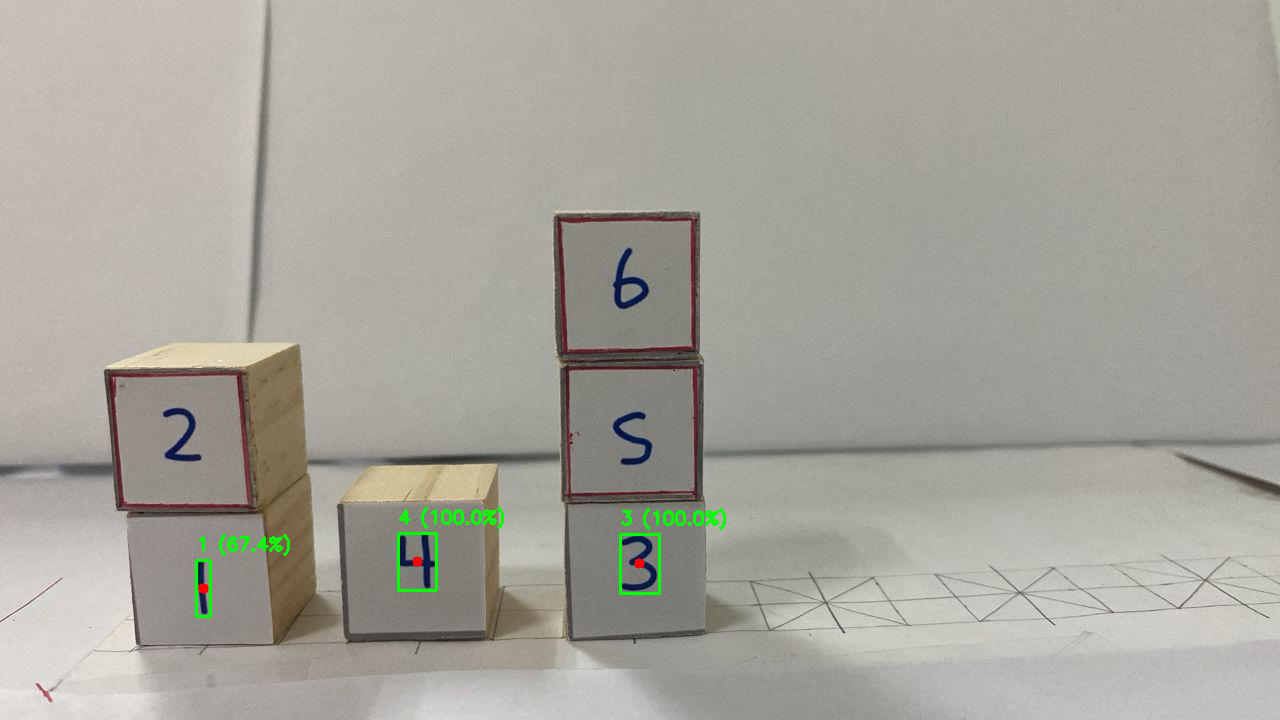

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Detected Digit: 5 with confidence 100.0% at center (633, 439)


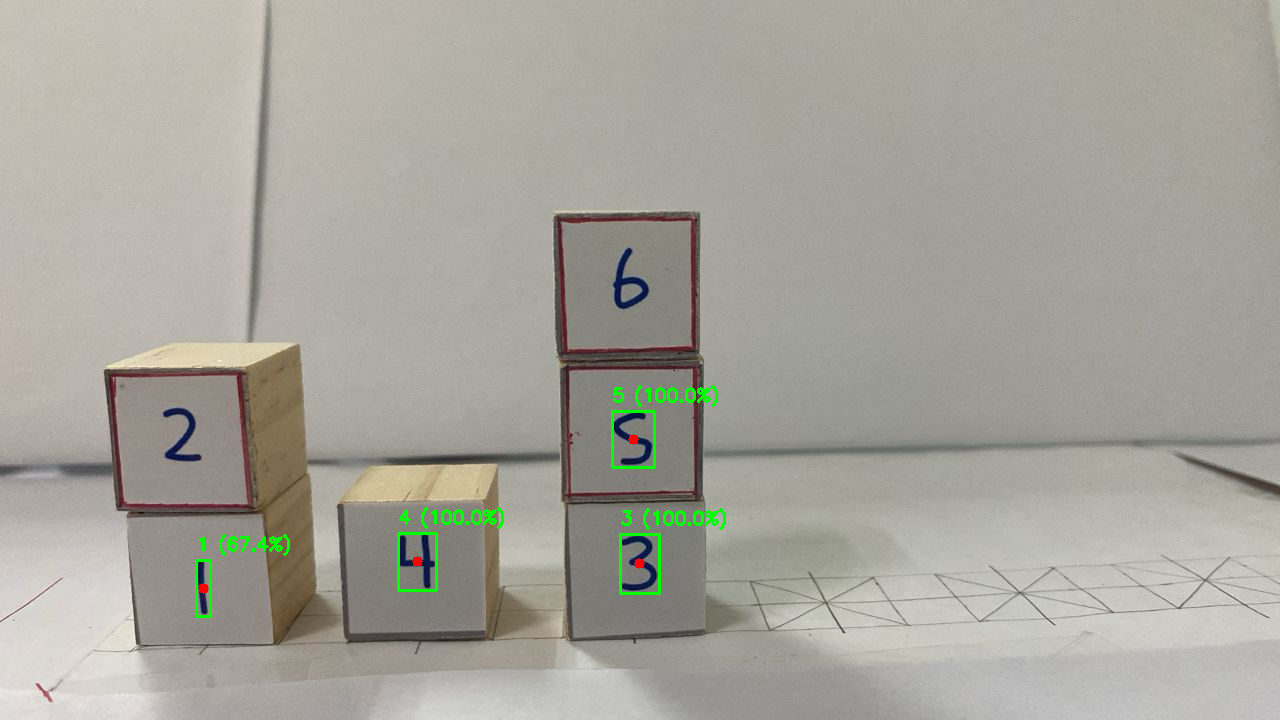

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Detected Digit: 2 with confidence 100.0% at center (182, 435)


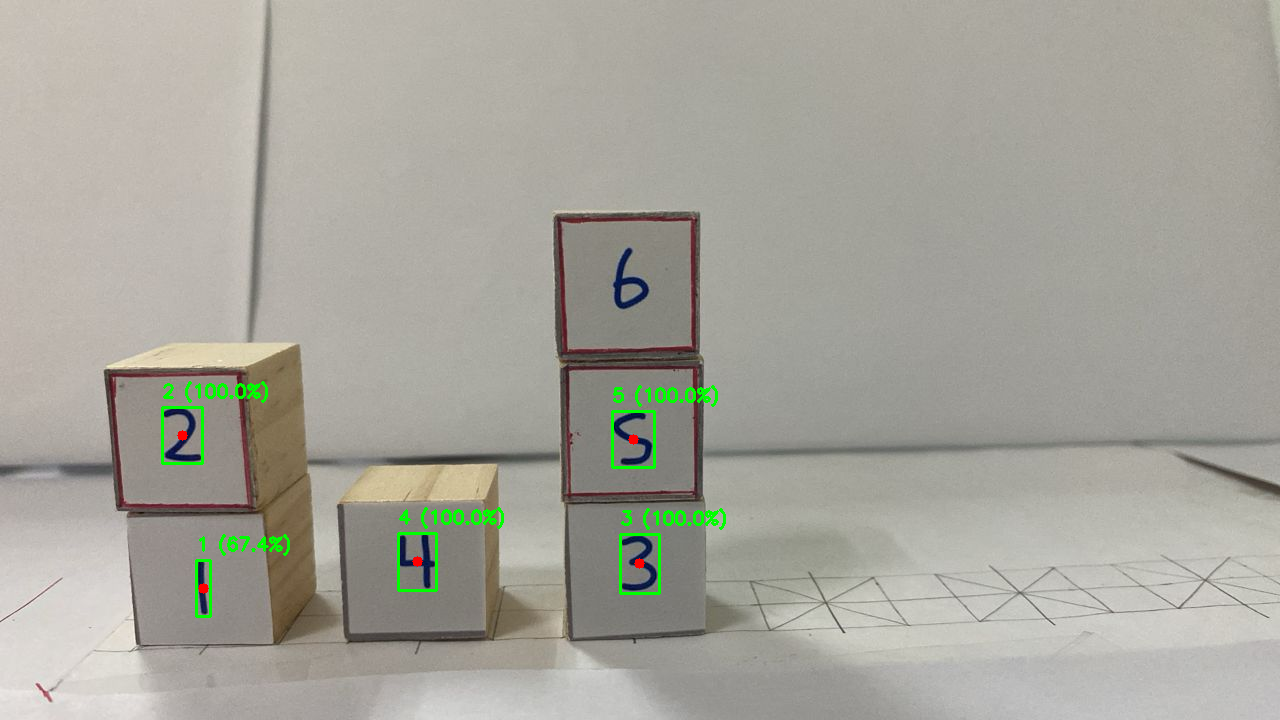

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Detected Digit: 6 with confidence 100.0% at center (631, 279)


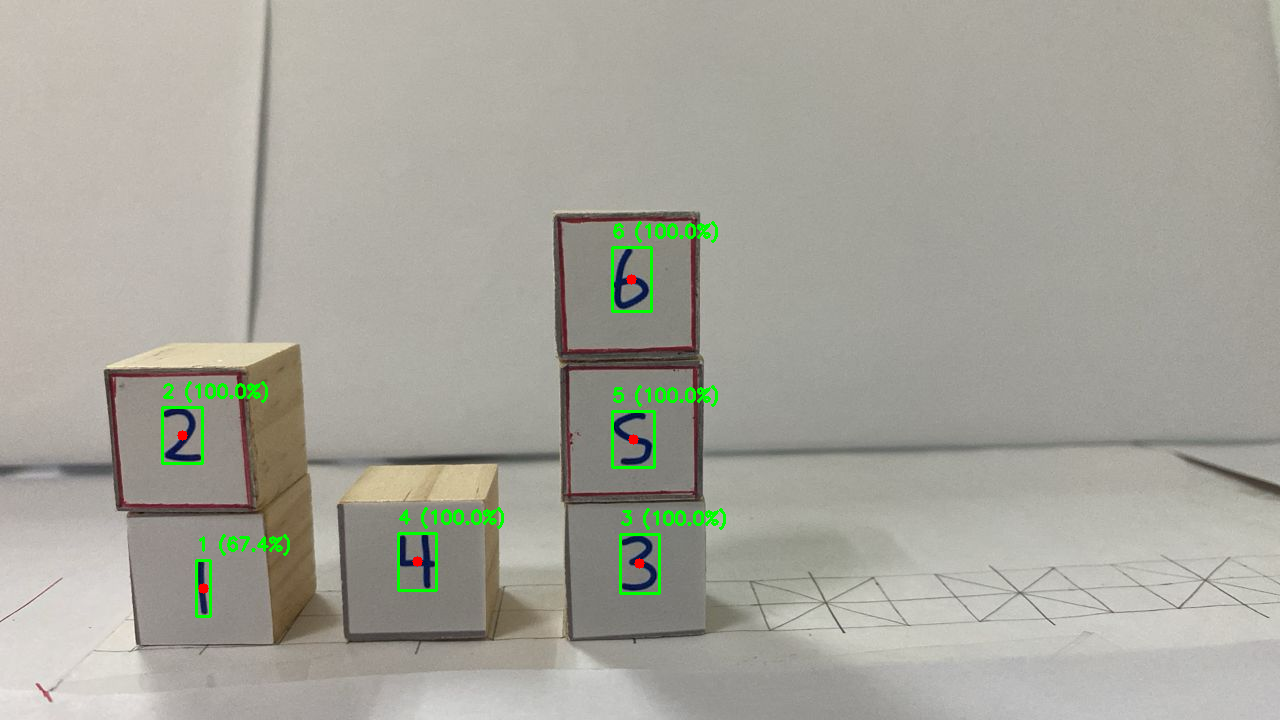

In [ ]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow

# Load the pre-trained model
model = load_model('mnist_digit_model.h5')

def process_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read the image at {image_path}.")
        return

    # Convert to HSV color space and threshold for blue color
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_hsv = np.array([100, 150, 0])
    upper_hsv = np.array([140, 255, 255])
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(mask, (5, 5), 0)
    binary = blurred

    # Use morphological dilation to refine digit contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilated = cv2.dilate(binary, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:  # Filter small contours by area
            x, y, w, h = cv2.boundingRect(contour)

            # Calculate the center of the bounding box
            cx = x + w // 2
            cy = y + h // 2

            # Extract and preprocess the ROI for digit prediction
            roi = dilated[y:y + h, x:x + w]
            roi_resized = cv2.resize(roi, (20, 20), interpolation=cv2.INTER_AREA)
            roi_padded = cv2.copyMakeBorder(roi_resized, 4, 4, 4, 4, cv2.BORDER_CONSTANT, value=0)

            # Prepare for model prediction
            roi_processed = roi_padded.reshape(1, 28, 28, 1).astype('float32') / 255.0

            # Predict the digit
            prediction = model.predict(roi_processed)
            class_index = np.argmax(prediction)
            confidence = np.max(prediction)

            # Draw bounding box, result, and center on the original image
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.circle(image, (cx, cy), 5, (0, 0, 255), -1)  # Red dot at the center
            cv2.putText(image, f"{class_index} ({confidence*100:.1f}%)", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Print the coordinates of the bounding box center
            print(f"Detected Digit: {class_index} with confidence {confidence*100:.1f}% at center ({cx}, {cy})")

    # Show final image with bounding boxes, centers, and predictions
            cv2_imshow(image)

# Example usage
image_path = "/content/2222.jpg"  # Replace with your image path
process_image(image_path)
